# Make classification data

In [1]:
from sklearn.datasets import make_circles

num_samples = 2000

X, y = make_circles(n_samples=num_samples,shuffle=True,noise=0.2,random_state=42)

In [2]:
X[:5]

array([[ 0.2510029 , -0.38424524],
       [-0.69646978,  0.86709522],
       [-0.4079322 ,  0.78906473],
       [ 0.84244495, -0.81868182],
       [ 0.00517398,  0.67734996]])

In [3]:
y[:5]

array([1, 0, 1, 0, 1])

In [4]:
X[:,0]

array([ 0.2510029 , -0.69646978, -0.4079322 , ...,  0.57638622,
       -0.84065001,  0.71085033])

In [5]:
import pandas as pd

df = pd.DataFrame({'X1': X[:,0], 'X2':X[:,1],'labels':y})

In [6]:
df.head()

,X1,X2,labels
0,0.251003,-0.384245,1
1,-0.696470,0.867095,0
2,-0.407932,0.789065,1
3,0.842445,-0.818682,0
4,0.005174,0.677350,1


In [7]:
df['labels'].value_counts()

labels
1    1000
0    1000
Name: count, dtype: int64

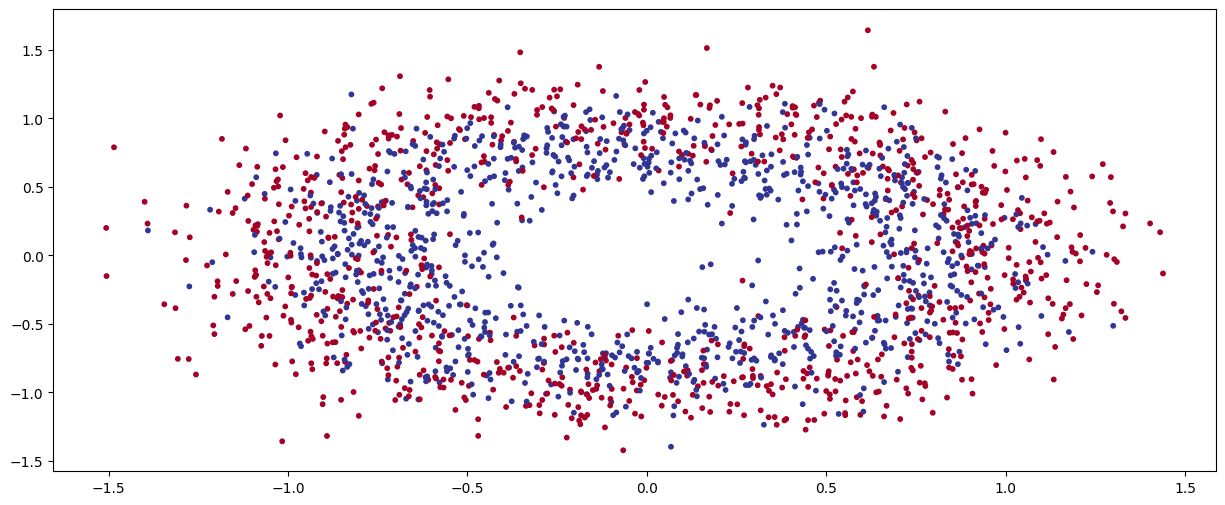

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.scatter(x=df['X1'],y=df['X2'],c=y ,s=10,cmap=plt.cm.RdYlBu)

In [9]:
X.shape,y.shape

((2000, 2), (2000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [ 0.2510029  -0.38424524] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

# Turn data into tensors
* Right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors.

In [11]:
X[:5]

array([[ 0.2510029 , -0.38424524],
       [-0.69646978,  0.86709522],
       [-0.4079322 ,  0.78906473],
       [ 0.84244495, -0.81868182],
       [ 0.00517398,  0.67734996]])

In [12]:
# Turn Data into Tensor
import torch

x = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

x[:5],y[:5]

(tensor([[ 0.2510, -0.3842],
         [-0.6965,  0.8671],
         [-0.4079,  0.7891],
         [ 0.8424, -0.8187],
         [ 0.0052,  0.6773]]),
 tensor([1., 0., 1., 0., 1.]))

# train and test splits

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split( x,y,test_size=0.26,random_state=42)
len(x_train),len(y_train), len(y_test),len(x_test)

(1480, 1480, 520, 520)

# Build Model

## Build model with Funtional api

In [14]:
import torch
import torch.nn as nn

# set up device if GPU present in system
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [15]:
class ClfModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2,out_features=5) # takes in 2 features (X), produces 5 features
      self.layer_2 = nn.Linear(in_features=5,out_features=1) # takes in 5 features input from previous output, produces 1 features.T_destination
      
    def forward(self,x):
       x = self.layer_1(x)
       x= self.layer_2(x)
       return x 
    

# model instance
model = ClfModel().to(device)
model

ClfModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**what's happening between self.layer_1 and self.layer_2**
* layer_1 takes 2 input features x1 and x2 produce output 5. this is known as hidden units or nurons.
* This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs.
* The number of hidden units you can use in neural network layers is a hyperparameter and there's no set in stone value you have to use.


## Build with Sequintial Method

In [16]:
# Another mehod to build model
model_2= nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

## Make prediction with untrained model

In [17]:
# Make predictions with the model
untrained_preds = model(x_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 520, Shape: torch.Size([520, 1])
Length of test samples: 520, Shape: torch.Size([520])

First 10 predictions:
tensor([[ 0.1350],
        [ 0.1214],
        [ 0.2912],
        [-0.1686],
        [-0.1308],
        [-0.1432],
        [ 0.2421],
        [ 0.0994],
        [-0.2150],
        [-0.0410]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 1.])


#  Setup loss function and optimizer
- For Regression Problem we using MAE as Loss Function
- And now binary classification problem use binary cross entropy(log loss) as loss function

In [18]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [19]:
# classification matrics
def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    accuracy = (correct/len(y_pred))*100
    return accuracy

# Model Traning

1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).
2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [20]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(x_test.to(device))[:5]
y_logits

tensor([[ 0.1350],
        [ 0.1214],
        [ 0.2912],
        [-0.1686],
        [-0.1308]], grad_fn=<SliceBackward0>)

In [21]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5337],
        [0.5303],
        [0.5723],
        [0.4579],
        [0.4673]], grad_fn=<SigmoidBackward0>)

If y_pred_probs >= 0.5, y=1 (class 1)
If y_pred_probs < 0.5, y=0 (class 0)

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(x_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 0., 0.], grad_fn=<SqueezeBackward0>)

## Building a training and testing loop

In [23]:
epochs = 100

# put data to target
x_train,y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device) , y_test.to(device)

In [24]:
for epoch in range(epochs):
    model.train()
    outout = model(x_train).squeeze()  # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(outout))
    loss = loss_fn(outout,y_train)
    train_accuracy = accuracy(y_train,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
	 # Test
    model.eval()
    with torch.no_grad():
      test_output = model(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_output))
      test_loss = loss_fn(test_output,y_test)
      test_accuracy = accuracy(y_test,test_pred)
      
    if epoch % 10==0:
       print(f"Epoch: {epoch} | Loss: {loss:.5f}, Tranin Accuracy: {train_accuracy:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")
      
    

Epoch: 0 | Loss: 0.69856, Tranin Accuracy: 50.14% | Test loss: 0.69905, Test acc: 50.19%
Epoch: 10 | Loss: 0.69843, Tranin Accuracy: 50.27% | Test loss: 0.69895, Test acc: 50.38%
Epoch: 20 | Loss: 0.69831, Tranin Accuracy: 50.14% | Test loss: 0.69885, Test acc: 50.38%
Epoch: 30 | Loss: 0.69820, Tranin Accuracy: 50.07% | Test loss: 0.69875, Test acc: 50.58%
Epoch: 40 | Loss: 0.69809, Tranin Accuracy: 50.07% | Test loss: 0.69866, Test acc: 50.58%
Epoch: 50 | Loss: 0.69798, Tranin Accuracy: 50.07% | Test loss: 0.69857, Test acc: 50.38%
Epoch: 60 | Loss: 0.69787, Tranin Accuracy: 50.07% | Test loss: 0.69848, Test acc: 50.38%
Epoch: 70 | Loss: 0.69777, Tranin Accuracy: 49.93% | Test loss: 0.69839, Test acc: 50.38%
Epoch: 80 | Loss: 0.69767, Tranin Accuracy: 49.80% | Test loss: 0.69831, Test acc: 50.58%
Epoch: 90 | Loss: 0.69758, Tranin Accuracy: 49.86% | Test loss: 0.69823, Test acc: 50.58%


# Make predictions and evaluate the model

In [25]:
import requests
from pathlib import Path

# download helper function scrip
if Path('helper_functions.py').is_file():
    print('Script Present in root dir')
else:
    response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py','wb') as f:
        f.write(response.content)
    print('helper_functions.py download completed')

Script Present in root dir


In [26]:
from helper_functions import plot_predictions, plot_decision_boundary

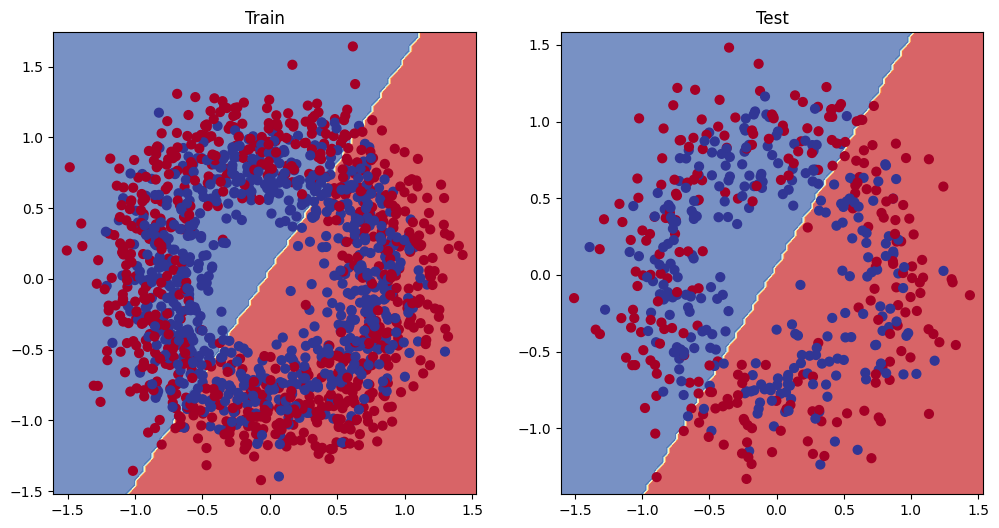

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

#  Improving a model

* Note: *because you can adjust all of these by hand, they're referred to as hyperparameters*.

And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

In [28]:
class ClfModelV2(nn.Module):
   def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(2,10)
      self.layer_2 = nn.Linear(10,20)
      self.layer_3 = nn.Linear(20,1)
      self.relu = nn.ReLU()

		
   def forward(self,x):
      x = self.relu( self.layer_1(x))
      x = self.relu(self.layer_2(x))
      x = self.relu(self.layer_3(x))
      return x
   
model_v2= ClfModelV2().to(device)

In [29]:
model_v2

ClfModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_v2.parameters(), lr=0.01)

In [31]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = x_train.to(device), y_train.to(device)
X_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_v2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_v2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_v2(x_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69610, Accuracy: 49.46% | Test loss: 0.69353, Test acc: 51.54%
Epoch: 100 | Loss: 0.69426, Accuracy: 50.68% | Test loss: 0.69277, Test acc: 55.00%
Epoch: 200 | Loss: 0.69358, Accuracy: 48.85% | Test loss: 0.69291, Test acc: 52.69%
Epoch: 300 | Loss: 0.69324, Accuracy: 49.46% | Test loss: 0.69307, Test acc: 50.96%
Epoch: 400 | Loss: 0.69319, Accuracy: 50.47% | Test loss: 0.69310, Test acc: 50.58%
Epoch: 500 | Loss: 0.69318, Accuracy: 50.61% | Test loss: 0.69309, Test acc: 49.81%
Epoch: 600 | Loss: 0.69316, Accuracy: 50.61% | Test loss: 0.69308, Test acc: 50.00%
Epoch: 700 | Loss: 0.69314, Accuracy: 50.74% | Test loss: 0.69306, Test acc: 50.19%
Epoch: 800 | Loss: 0.69312, Accuracy: 50.68% | Test loss: 0.69304, Test acc: 50.38%
Epoch: 900 | Loss: 0.69309, Accuracy: 50.74% | Test loss: 0.69298, Test acc: 51.35%


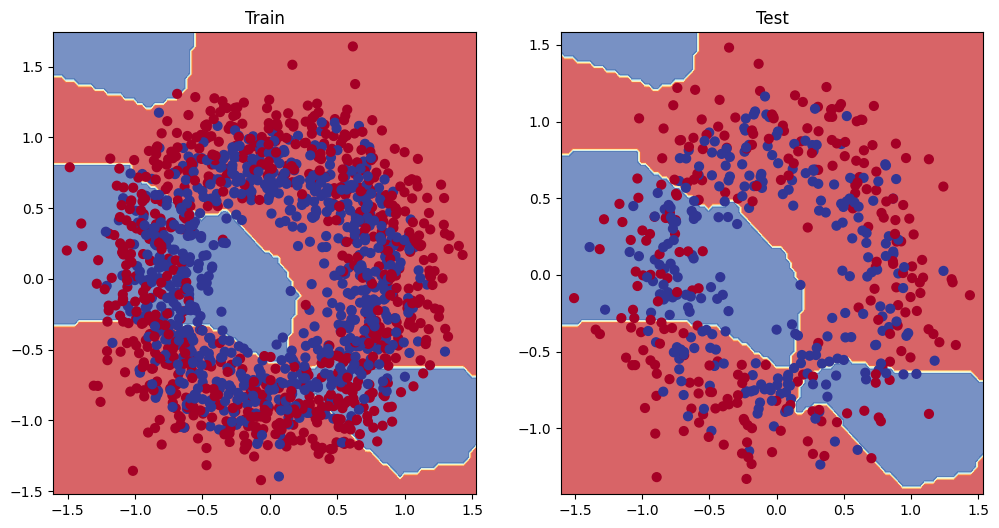

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v2, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v2, x_test, y_test)

# Multi-class classification

## Creating multi-class classification data

In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [34]:
num_class=4
num_features = 3
random_seed =42

x_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=num_features,
    centers=num_class,
    random_state=random_seed,
    cluster_std=1.5
)

## Data to tensor

In [35]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

print(x_blob[:5])
print(y_blob[:5])

tensor([[ -8.7147,   5.1372,   1.5585],
        [  3.0065, -11.5325,   8.7140],
        [  1.8581,  -8.4531,  10.3169],
        [ -5.2194,   8.5004,   1.9934],
        [  4.5265,  -6.5185,  -2.9776]])
tensor([2., 3., 3., 2., 1.])


## split data

In [36]:
x_train,x_test,y_train,y_test = train_test_split( x_blob,y_blob,test_size=0.26,random_state=42)
len(x_train),len(y_train), len(y_test),len(x_test)

(740, 740, 260, 260)

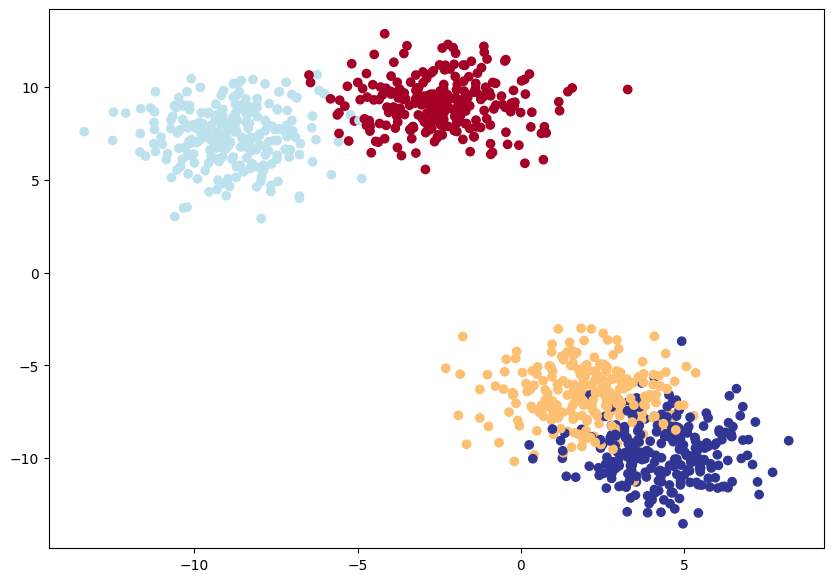

In [37]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Multi Classs Model

In [38]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
x_train.shape

torch.Size([740, 3])

In [40]:
from torch import nn

class MultiClfModel(nn.Module):
    def __init__(self,input_features, output_features, hidden_units=8):
      super().__init__()
      self.linear_layers = nn.Sequential(
         nn.Linear(in_features=input_features,out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units,out_features=hidden_units),
         nn.ReLU(),
         nn.Linear(in_features=hidden_units,out_features=output_features)
		)
    def forward(self,x):
       return self.linear_layers(x)

In [41]:
multiclf_model =MultiClfModel(input_features=num_features,output_features=num_class,hidden_units=8).to(device)
multiclf_model

MultiClfModel(
  (linear_layers): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [42]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(multiclf_model.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

##  Getting prediction probabilities for a multi-class PyTorch model

In [43]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
multiclf_model(x_train.to(device))[:5]

tensor([[-0.8759, -1.0079, -0.3134,  0.4306],
        [-0.9580, -1.1198, -0.4113,  0.2531],
        [-0.5187, -0.5968, -0.0312, -0.1700],
        [-0.3497, -0.4033,  0.0696, -0.0186],
        [-0.4218, -0.5422, -0.0108, -0.0624]], grad_fn=<SliceBackward0>)

In [45]:
x_train[0]

tensor([-3.7680,  8.5505,  5.1368])

In [44]:
# How many elements in a single prediction sample?
multiclf_model(x_train.to(device))[0].shape, num_class

(torch.Size([4]), 4)

In [46]:
# make prediction logit with model

y_pred_prob = torch.softmax(multiclf_model(x_test).to(device),dim=1)
print(multiclf_model(x_test).to(device))
print(y_pred_prob[:5])

tensor([[-0.4307, -0.6408, -0.1174, -0.0820],
        [-0.3995, -0.4873, -0.0776, -0.0075],
        [-0.2897, -0.3019,  0.1016,  0.0576],
        ...,
        [-0.2896, -0.3012,  0.1016,  0.0597],
        [-0.3785, -0.5647, -0.0899, -0.0507],
        [-0.9915, -1.0786, -0.3770,  0.6087]], grad_fn=<AddmmBackward0>)
tensor([[0.2176, 0.1764, 0.2977, 0.3084],
        [0.2094, 0.1918, 0.2889, 0.3099],
        [0.2048, 0.2023, 0.3029, 0.2899],
        [0.2095, 0.1795, 0.3127, 0.2982],
        [0.1374, 0.1148, 0.2419, 0.5059]], grad_fn=<SliceBackward0>)


In [49]:

# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_prob[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [50]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_prob[0])
print(torch.argmax(y_pred_prob[0]))

tensor([0.2176, 0.1764, 0.2977, 0.3084], grad_fn=<SelectBackward0>)
tensor(3)


##  Training and testing loop for a multi-class PyTorch model

In [56]:
# Set number of epochs
epochs = 1000

# Move data to device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

# Ensure labels are of type long
y_train = y_train.long()
y_test = y_test.long()

for epoch in range(epochs):
    multiclf_model.train()

    # Forward pass
    output = multiclf_model(x_train)
    
    # Compute loss (use raw logits, no softmax)
    loss = loss_fn(output, y_train)  # y_train must be long

    # Predict class indices
    y_pred = output.argmax(dim=1)
    
    # Compute training accuracy
    train_acc = accuracy(y_train, y_pred)

    # Optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Model Testing Performance
    multiclf_model.eval()
    with torch.no_grad():
        test_output = multiclf_model(x_test)
        test_loss = loss_fn(test_output, y_test)  # y_test must be long
        test_pred = test_output.argmax(dim=1)
        test_acc = accuracy(y_test, test_pred)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Train Accuracy: {train_acc:.2f}% | '
              f'Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%')


Epoch: 0 | Loss: 1.58179 | Train Accuracy: 2.43% | Test Loss: 1.35227 | Test Accuracy: 19.23%
Epoch: 10 | Loss: 0.80674 | Train Accuracy: 73.78% | Test Loss: 0.80107 | Test Accuracy: 75.38%
Epoch: 20 | Loss: 0.41439 | Train Accuracy: 88.24% | Test Loss: 0.38151 | Test Accuracy: 93.46%
Epoch: 30 | Loss: 0.13021 | Train Accuracy: 99.19% | Test Loss: 0.11757 | Test Accuracy: 99.62%
Epoch: 40 | Loss: 0.06310 | Train Accuracy: 99.46% | Test Loss: 0.05951 | Test Accuracy: 100.00%
Epoch: 50 | Loss: 0.04350 | Train Accuracy: 99.46% | Test Loss: 0.04129 | Test Accuracy: 100.00%
Epoch: 60 | Loss: 0.03425 | Train Accuracy: 99.46% | Test Loss: 0.03241 | Test Accuracy: 100.00%
Epoch: 70 | Loss: 0.02879 | Train Accuracy: 99.46% | Test Loss: 0.02715 | Test Accuracy: 100.00%
Epoch: 80 | Loss: 0.02519 | Train Accuracy: 99.46% | Test Loss: 0.02368 | Test Accuracy: 100.00%
Epoch: 90 | Loss: 0.02265 | Train Accuracy: 99.59% | Test Loss: 0.02122 | Test Accuracy: 100.00%
Epoch: 100 | Loss: 0.02081 | Train A

## Evaluating predictions

In [57]:
multiclf_model.eval()
with torch.no_grad():
    y_pred = multiclf_model(x_test)
y_pred[:5]

tensor([[  1.5034,  -0.3457, -10.6205,  12.5030],
        [ -6.8778,   6.5508,  -2.2395,  -5.2553],
        [ -8.2125,   8.2575,  -4.0581,  -3.9932],
        [  0.9885,  -0.1302,  -8.9118,  10.8824],
        [ -4.3282,  -5.4248,   5.8738,  -8.1233]])

In [58]:
# Getting probalistic result
y_pred_probs = torch.softmax(y_pred,dim=1)

# prediction hightest probabilites
y_preds = torch.argmax(y_pred_probs,dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy(y_true=y_test, y_pred=y_preds)}%")


Predictions: tensor([3, 1, 1, 3, 2, 3, 1, 1, 1, 3])
Labels: tensor([3, 1, 1, 3, 2, 3, 1, 1, 1, 3])
Test accuracy: 99.61538461538461%


# classification evaluation metrics

In [61]:
pip install torchmetrics

   ---------------------------------------- 0.0/960.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/960.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/960.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/960.9 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/960.9 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/960.9 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/960.9 kB ? eta -:--:--
   -------------------- ----------------- 524.3/960.9 kB 399.0 kB/s eta 0:00:02
   -------------------- ----------------- 524.3/960.9 kB 399.0 kB/s eta 0:00:02
   -------------------- ----------------- 524.3/960.9 kB 399.0 kB/s eta 0:00:02
   ------------------------------- ------ 786.4/960.9 kB 385.5 kB/s eta 0:00:01
   ------------------------------- ------ 786.4/960.9 kB 385.5 kB/s eta 0:00:01
   -------------------------------------- 960.9/960.9 kB 399.3 kB/s eta 0:00:00
Note: you may nee

In [62]:
from torchmetrics import Accuracy

In [63]:
metrics_accuracy = Accuracy(task='multiclass', num_classes=num_class).to(device)

# calculate accuracy
metrics_accuracy(y_preds,y_test)

tensor(0.9962)

In [68]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Ensure y_test and y_preds are NumPy arrays or PyTorch tensors converted to NumPy
y_test = y_test.cpu().numpy()  # If using PyTorch, move to CPU and convert to NumPy
y_preds = y_preds.cpu().numpy()

# Compute precision and recall
print(f'Precision Score: {precision_score(y_test, y_preds, average="macro"):.2f}')
print(f'Recall Score: {recall_score(y_test, y_preds, average="macro"):.2f}')

# Classification report for a full breakdown
print(classification_report(y_test, y_preds))


Precision Score: 1.00
Recall Score: 1.00
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       1.00      1.00      1.00        64
           2       1.00      0.98      0.99        58
           3       1.00      1.00      1.00        76

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



# Exercises

In [1]:
from sklearn.datasets import load_iris

x,y = load_iris(return_X_y=True)

In [2]:
x[:6]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4]])

In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:

x = torch.from_numpy(x).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [18]:
import torch
import torch.nn as nn

In [19]:
class IrisModel(nn.Module):
    def __init__(self,input_features=4,output_features=3,hidden_unit=8):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit,out_features=hidden_unit),
            nn.ReLU(),
            nn.Linear(in_features=hidden_unit,out_features=output_features)     
		  )
    def forward(self,x):
        return self.linear_layer(x)
    
model = IrisModel()

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

In [21]:
type(x_train),type(y_train)

(torch.Tensor, torch.Tensor)

In [22]:
type(x_train),type(y_train)

(torch.Tensor, torch.Tensor)

In [ ]:
# testing untrain model
y_probs_untrain_model = model(x_train[3])
pred_label = torch.argmax(y_probs_untrain_model)

In [39]:
print(f'Actual label: {y_train[3]}')
print(f'predicted label: {pred_label}')

Actual label: 1.0
predicted label: 0


In [40]:
# Traning and eval
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

x_train,x_test = x_train.to(device),x_test.to(device)
y_train,y_test = y_train.long().to(device), y_test.long().to(device)


In [41]:
# classification matrics
def accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    accuracy = (correct/len(y_pred))*100
    return accuracy

In [42]:
import torch
from torchmetrics import Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy = Accuracy(task='multiclass', num_classes=3).to(device)

epochs = 1000

for epoch in range(epochs):
    model.train()
    output = model(x_train)
    loss = loss_fn(output, y_train)
    
    y_pred = torch.argmax(output, dim=1)
    train_acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_output = model(x_test)
        test_preds = torch.argmax(test_output, dim=1)
        test_acc = accuracy(test_preds, y_test)
        test_loss = loss_fn(test_output, y_test)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc.item():.4f} | Test Acc: {test_acc.item():.4f} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")


Epoch 1/1000 | Train Acc: 0.3125 | Test Acc: 0.3158 | Train Loss: 1.1555 | Test Loss: 1.1314
Epoch 2/1000 | Train Acc: 0.3393 | Test Acc: 0.2895 | Train Loss: 1.0918 | Test Loss: 1.0807
Epoch 3/1000 | Train Acc: 0.3482 | Test Acc: 0.3421 | Train Loss: 1.0366 | Test Loss: 0.9842
Epoch 4/1000 | Train Acc: 0.3661 | Test Acc: 0.7105 | Train Loss: 0.9769 | Test Loss: 0.9086
Epoch 5/1000 | Train Acc: 0.6518 | Test Acc: 0.7105 | Train Loss: 0.9261 | Test Loss: 0.8146
Epoch 6/1000 | Train Acc: 0.6518 | Test Acc: 0.7105 | Train Loss: 0.8248 | Test Loss: 0.7336
Epoch 7/1000 | Train Acc: 0.6518 | Test Acc: 0.7105 | Train Loss: 0.7438 | Test Loss: 0.6199
Epoch 8/1000 | Train Acc: 0.6518 | Test Acc: 0.7368 | Train Loss: 0.6484 | Test Loss: 0.5527
Epoch 9/1000 | Train Acc: 0.7143 | Test Acc: 0.7105 | Train Loss: 0.5894 | Test Loss: 0.4861
Epoch 10/1000 | Train Acc: 0.6875 | Test Acc: 0.7105 | Train Loss: 0.5317 | Test Loss: 0.4341
Epoch 11/1000 | Train Acc: 0.6518 | Test Acc: 0.7105 | Train Loss: 0.